In [1]:
# OCR - pre processing techiniques
import pytesseract
from pytesseract import Output

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image, ImageOps
import re

from imutils.object_detection import non_max_suppression                # pip install imutils


In [3]:
# pre-processing
detector = './models/frozen_east_text_detection.pb'
width, height = 320, 320            # 이미지에 맞게 크기 설정 (32 배수로 설정할 것)
image_path = './content/cup.jpg'
min_confidence = 0.9

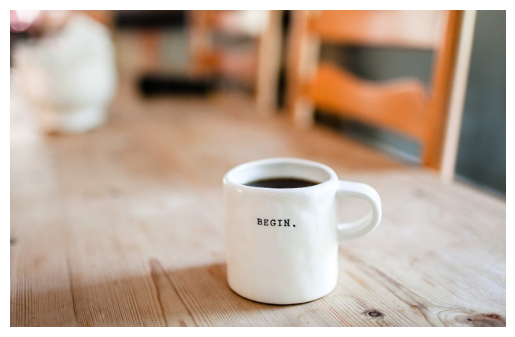

In [4]:
img = Image.open(image_path).convert("RGB")
img_cv = np.array(img)

plt.imshow(img_cv, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
original = img_cv.copy()
img_cv.shape

(480, 750, 3)

In [6]:
H = img_cv.shape[0]
W = img_cv.shape[1]

proportion_W = W / float(width)
proportion_H = H / float(height)
print(proportion_W, proportion_H)

2.34375 1.5


320 320


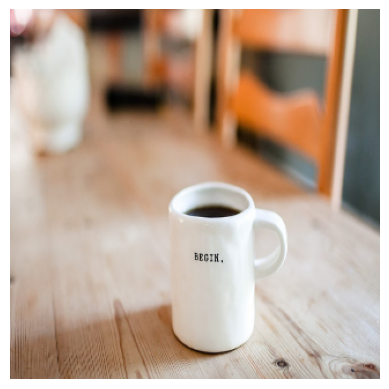

In [7]:
# resize
img_cv = cv2.resize(img_cv, (width, height))
H = img_cv.shape[0]
W = img_cv.shape[1]
print(H, W)

plt.imshow(img_cv, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
layers_names = ['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3']
neural_network = cv2.dnn.readNet(detector)

In [9]:
img_cv.shape

(320, 320, 3)

In [10]:
# cv2로 읽으면 BGR순이라서 swapRB=True
# Image.open 으로 읽으면 RGB순이라서 swapRB=False
blob = cv2.dnn.blobFromImage(img_cv, 1.0, (W,H), swapRB=False, crop=False)

In [11]:
blob.shape          # batch size

(1, 3, 320, 320)

In [12]:
neural_network.setInput(blob)
scores, geometry = neural_network.forward(layers_names)

In [13]:
scores

array([[[[1.4775183e-07, 5.3355325e-07, 6.1831190e-07, ...,
          2.3887444e-06, 2.1422467e-07, 1.9741562e-06],
         [2.2155248e-07, 8.2297476e-08, 1.5269326e-07, ...,
          3.8021703e-06, 2.4969086e-07, 2.0974837e-06],
         [2.4107598e-07, 2.5650635e-07, 6.7496660e-07, ...,
          4.4842459e-06, 6.0891395e-08, 2.5159140e-06],
         ...,
         [5.1902941e-07, 1.3470725e-07, 3.8078490e-08, ...,
          1.7954446e-06, 7.7535549e-07, 5.4700849e-06],
         [2.8565972e-07, 8.5580076e-08, 1.1289849e-07, ...,
          1.1354846e-06, 9.0157494e-07, 5.0782419e-06],
         [7.2199100e-08, 8.4333314e-09, 5.4603602e-09, ...,
          1.9142327e-07, 3.1659505e-07, 1.0240367e-07]]]],
      shape=(1, 1, 80, 80), dtype=float32)

In [14]:
geometry

array([[[[ 1.54848892e+02,  1.01938675e+02,  1.08211121e+02, ...,
           1.33965591e+02,  1.27577316e+02,  1.46967972e+02],
         [ 1.19407852e+02,  6.46941986e+01,  7.18581772e+01, ...,
           9.02676010e+01,  8.52865829e+01,  1.03320297e+02],
         [ 1.22548691e+02,  6.90612030e+01,  7.86800308e+01, ...,
           1.06369835e+02,  1.01670235e+02,  1.14973686e+02],
         ...,
         [ 1.16457314e+02,  4.99966507e+01,  3.75176544e+01, ...,
           8.21259842e+01,  8.12639847e+01,  1.21695618e+02],
         [ 1.27623383e+02,  5.88199654e+01,  4.84033051e+01, ...,
           8.31772232e+01,  8.09340973e+01,  1.11183907e+02],
         [ 1.26661522e+02,  7.53629608e+01,  6.93248215e+01, ...,
           1.27025345e+02,  1.18697968e+02,  1.47223724e+02]],

        [[ 1.09559761e+02,  9.52128754e+01,  9.08699265e+01, ...,
           1.00495575e+02,  9.43882065e+01,  1.12618622e+02],
         [ 8.27181091e+01,  5.77866745e+01,  5.62353096e+01, ...,
           6.53349609e

In [15]:
rows, columns = scores.shape[2:4]
print(rows, columns)

80 80


In [16]:
# decoding values
boxes = []
confidences = []

def geometric_data(geometry, y):
    xData0 = geometry[0,0,y]
    xData1 = geometry[0,1,y]
    xData2 = geometry[0,2,y]
    xData3 = geometry[0,3,y]
    angles_data = geometry[0,4,y]
    return angles_data, xData0, xData1, xData2, xData3

def geometric_calculation(angles_data, xData0, xData1, xData2, xData3):
    (offsetX, offsetY) = (x * 4.0, y * 4.0)
    angle = angles_data[x]
    cos = np.cos(angle)
    sin = np.sin(angle)
    h = xData0[x] + xData2[x]
    w = xData1[x] + xData3[x]

    endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
    endY = int(offsetY - (sin*xData1[x]) + (cos* xData2[x]))

    beginX = int(endX - w)
    beginY = int(endY - h)

    return beginX, beginY, endX, endY


In [17]:
for y in range(0, rows):
    data_scores = scores[0,0,y]
    angles_data, xData0, xData1, xData2, xData3 = geometric_data(geometry, y)
    print(data_scores)
    print(angles_data, xData0, xData1, xData2, xData3)
    print('--------')
    for x in range(0, columns):
        if data_scores[x] < min_confidence:
            continue
        
        beginX, beginY, endX, endY = geometric_calculation(angles_data, xData0, xData1, xData2, xData3)
        confidences.append(data_scores[x])
        boxes.append((beginX, beginY, endX, endY))

[1.4775183e-07 5.3355325e-07 6.1831190e-07 5.4498480e-07 6.8389460e-07
 6.3538363e-07 2.8739106e-07 1.1796508e-07 1.4145149e-07 1.9870522e-07
 1.9250447e-07 1.7849250e-07 3.2116756e-07 1.1000186e-06 1.8538535e-06
 7.2049903e-07 2.2694773e-07 1.9305345e-07 2.7782812e-07 4.6434533e-07
 5.4333816e-07 6.3162935e-07 6.5712828e-07 6.7843467e-07 6.9376136e-07
 5.5208506e-07 4.2479184e-07 3.1016791e-07 4.7803371e-07 4.5292870e-07
 5.1470943e-07 5.0100130e-07 3.5401621e-07 4.9244062e-07 2.2611391e-06
 3.2066059e-06 2.2184138e-06 1.9173272e-06 1.9552849e-06 2.5295287e-06
 3.1743598e-06 2.3743835e-06 3.7373130e-07 5.9925412e-08 7.6657173e-08
 1.3193031e-07 1.9002201e-07 3.2695496e-07 1.9928707e-07 1.4942634e-07
 2.1175209e-07 2.1544535e-07 2.3616482e-07 3.0993047e-07 3.7835929e-07
 4.7277859e-07 6.3466234e-07 8.9479857e-07 1.0728420e-06 9.4951156e-07
 9.8073758e-07 1.1685462e-06 1.7454752e-06 2.2706320e-06 2.2299869e-06
 2.2622305e-06 2.2908034e-06 2.4939200e-06 2.0356615e-06 8.0369875e-07
 4.755

In [18]:
confidences

[np.float32(0.9995617),
 np.float32(0.99982554),
 np.float32(0.9997718),
 np.float32(0.9994678),
 np.float32(0.96625125),
 np.float32(0.96421045),
 np.float32(0.9993309),
 np.float32(0.99968016),
 np.float32(0.99951243)]

In [19]:
boxes

[(156, 208, 190, 220),
 (157, 208, 187, 220),
 (157, 208, 186, 220),
 (158, 207, 186, 220),
 (156, 207, 187, 221),
 (157, 207, 188, 220),
 (158, 208, 187, 221),
 (158, 208, 187, 221),
 (157, 208, 188, 221)]

In [20]:
detections = non_max_suppression(np.array(boxes), probs=confidences)
detections

array([[157, 208, 187, 220]])

In [21]:
proportion_H, proportion_W

(1.5, 2.34375)

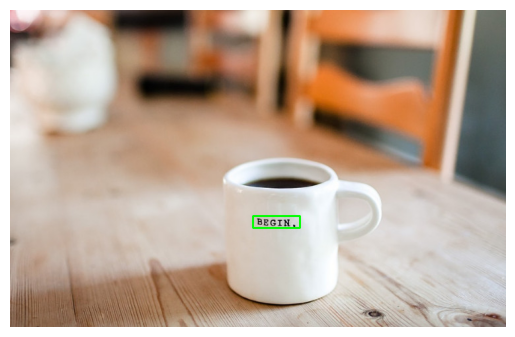

In [22]:
img_copy = original.copy()
for (beginX, beginY, endX, endY) in detections:
    beginX = int(beginX * proportion_W)
    beginY = int(beginY * proportion_H)
    endX = int(endX * proportion_W)
    endY = int(endY * proportion_H)

    roi = img_copy[beginY:endY, beginX:endX]

    cv2.rectangle(img_copy, (beginX, beginY), (endX, endY), (0, 255, 0), 2)

plt.imshow(img_copy, cmap='gray')
plt.axis('off')
plt.show()

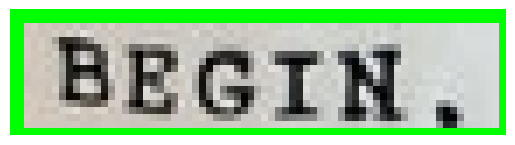

In [23]:
plt.imshow(roi, cmap='gray')
plt.axis('off')
plt.show()

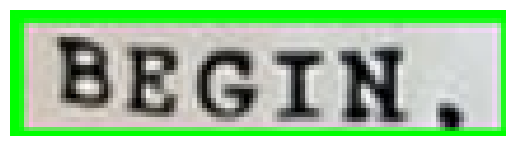

In [24]:
roi = cv2.resize(roi, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
plt.imshow(roi, cmap='gray')
plt.axis('off')
plt.show()

In [25]:
!tesseract --help-psm

Page segmentation modes (PSM):
  0|osd_only                Orientation and script detection (OSD) only.
  1|auto_osd                Automatic page segmentation with OSD.
  2|auto_only               Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3|auto                    Fully automatic page segmentation, but no OSD. (Default)
  4|single_column           Assume a single column of text of variable sizes.
  5|single_block_vert_text  Assume a single uniform block of vertically aligned text.
  6|single_block            Assume a single uniform block of text.
  7|single_line             Treat the image as a single text line.
  8|single_word             Treat the image as a single word.
  9|circle_word             Treat the image as a single word in a circle.
 10|single_char             Treat the image as a single character.
 11|sparse_text             Sparse text. Find as much text as possible in no particular order.
 12|sparse_text_osd         Sparse text with OSD.
 13|

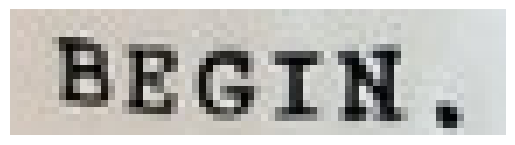

BEGIN.



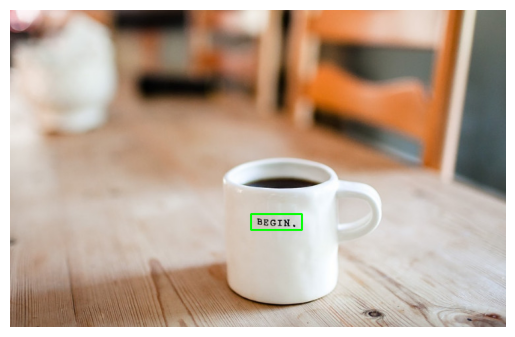

In [26]:
config_tesseract = '--tessdata-dir tessdata --psm 7'

img_copy = original.copy()
margin = 3

for (beginX, beginY, endX, endY) in detections:
    beginX = int(beginX * proportion_W)
    beginY = int(beginY * proportion_H)
    endX = int(endX * proportion_W)
    endY = int(endY * proportion_H)

    roi = img_copy[beginY:endY, beginX:endX]
    plt.imshow(roi, cmap='gray')
    plt.axis('off')
    plt.show()

    text = pytesseract.image_to_string(roi, lang='eng+kor+kor_vert', config=config_tesseract)
    print(text)

    cv2.rectangle(img_copy, (beginX-margin, beginY-margin), (endX+margin, endY+margin), (0, 255, 0), 2)

plt.imshow(img_copy, cmap='gray')
plt.axis('off')
plt.show()